<a href="https://colab.research.google.com/github/DipeshChothwe/PRODUCT-REVIEW-SUMMARIZATION/blob/main/Summary_words_from_reviews_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
reviews = pd.read_json('/content/drive/My Drive/NLP/Cell_Phones_and_Accessories.json')


# **Understanding the data**

In [4]:
reviews.head(1)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None


In [5]:
reviews.describe()

,Rating,Review_timestamp
count,760450.000000,7.604500e+05
mean,4.221357,1.440417e+09
std,1.232186,4.563251e+07
min,1.000000,1.035331e+09
25%,4.000000,1.416355e+09
50%,5.000000,1.444349e+09
75%,5.000000,1.470442e+09
max,5.000000,1.538438e+09


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760450 entries, 0 to 760449
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Rating            760450 non-null  int64 
 1   Rev_verify        760450 non-null  bool  
 2   Review_Date       760450 non-null  object
 3   IC                760450 non-null  object
 4   Prod_meta         407826 non-null  object
 5   Reviewer_Name     760359 non-null  object
 6   Review            759920 non-null  object
 7   Rev_summ          760095 non-null  object
 8   Review_timestamp  760450 non-null  int64 
 9   Useful            62200 non-null   object
 10  Prod_img          18194 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 64.5+ MB


In [7]:
i = reviews


**Distribution of number of reviews for each Item**

Distribution of number of reviews for each Item code:


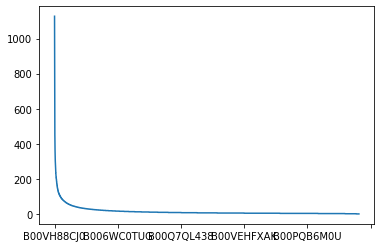

In [8]:
print('Distribution of number of reviews for each Item code:')
i['IC'].value_counts( sort=True).plot()


In [9]:
i['IC'].value_counts( sort=True)

B00VH88CJ0    1127
B005NF5NTK    1106
B019PV2I3G    1033
B00X5RV14Y    1018
B00P7N0320    1011
              ... 
B004N8OTFW       1
B00W2UE2NC       1
B005GAEF7S       1
B007XORQ08       1
B000VUNWV8       1
Name: IC, Length: 48134, dtype: int64

In [10]:
i['IC'].value_counts( sort=True).describe()

count    48134.000000
mean        15.798604
std         34.904772
min          1.000000
25%          4.000000
50%          7.000000
75%         14.000000
max       1127.000000
Name: IC, dtype: float64

**Most of the Items (75%) have less than 14 reviews.**

---



## **Null values detection**
To find number of Items that do not have any review or review summary

In [11]:
tempdf = i[['IC', 'Rev_summ', 'Review']]

Creating 'Nulldetect' from 'tempdf' having 4 columns: 


1.   IC
2.   count: Number of reviews for each IC (This includes empty reviews too)
1.   sum: Null review + null rev_summ; Thus this column can have max value of 2 when both review and summary of review is not present.
2.   ratio: sum column normalised to count; Value of 2 : no review or rev_summ (all fields have null entry)




In [12]:
nulldetect = tempdf.set_index('IC').isnull().sum(axis=1).groupby(level=0).agg(['count','sum'])
nulldetect = pd.DataFrame(nulldetect)
nulldetect['ratio'] = nulldetect['sum']/nulldetect['count']
nulldetect = nulldetect.sort_values(by=['ratio'], ascending=False)
print("\'IC\' \'Number of reviews\' \'Total Null reviews and review summary\' \'fractio of null reviews\'")
nulldetect.head(10)


'IC' 'Number of reviews' 'Total Null reviews and review summary' 'fractio of null reviews'


,count,sum,ratio
IC,,,
B013UK9URK,1,2,2.000000
B00H8N7MU8,2,1,0.500000
B01EO2PONW,2,1,0.500000
B00AV114GW,2,1,0.500000
B017QCSG6E,4,2,0.500000
B017QWXHQ8,2,1,0.500000
B0195FBAP4,4,2,0.500000
B00FXQ40CA,2,1,0.500000
B00ULPH37M,3,1,0.333333


**Except for "B013UK9URK", all IC's have atleast one review and one summary for review**



---





In [13]:
frequency = pd.DataFrame(nulldetect['ratio'].value_counts())
frequency.sort_index(ascending=False)


,ratio
2.000000,1
0.500000,7
0.333333,22
0.285714,1
0.250000,25
...,...
0.001385,1
0.001353,1
0.001335,1
0.000904,1



---



# **Data selection for NLP model**

In [14]:
reviews.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

**Idea behind column selection:**

1.   **Rating:** Ratings are not important for identification of key words. 
Using ratings will create a bias towards words from either high or low rating reviews.
2.   **Rev_verify:** Considering low amount of data per IC, Rev_verify was not selected for model. However, verified reviews could be given higher weightage than non verified.
1.   **Useful:** More importance is given to useful reviews as they helped other customer decide.
1.   **Review_Date:** Does not influence review unless a product had been modified.  
2.   **Prod_meta:** Does not influence review. However, sentiment for each feature in product meta data could be found. But that is not the problem statement.
1.   **Reviewer_Name:** Does not influence review.
2.   **Review and Rev_summ:** Required. Trivial.

1.   **Review_timestamp:** Does not influence review.
2.   **Prod_img:** Does not influence review.

In [15]:
reviews_data = reviews[['Rating', 'IC', 'Review', 'Rev_summ', 'Useful']]
reviews_data.head(2)

,Rating,IC,Review,Rev_summ,Useful
0,5,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,None
1,5,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,None


In [16]:
#"Useful" column has "None" values. Thus we replace them by 0.
#reviews_data['Useful'] = reviews_data['Useful'].fillna(0)
#reviews_data.head(2)

In [17]:
reviews_data['Useful'] = reviews_data['Useful'].replace(',','',regex=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
reviews_data['Useful'] = reviews_data['Useful'].fillna(0)
reviews_data['Useful'] = reviews_data['Useful'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:

reviews_data['Useful'].describe()

count    760450.000000
mean          0.777457
std          10.054148
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1737.000000
Name: Useful, dtype: float64

In [20]:
k = reviews_data['Useful']

# **Model**

**Using "useful" column:**

Useful score is important as it tells how useful the information in that particular review is.

---



1.   **weight of a word review** = (useful score)* string (i.e. multiplying string for useful score times); However, this increases load on system and having very high weight doesnt help as the difference is good enough after useful score = 6. Thus Useful scores more than 6 will be replaced with 6.



> However, to use this we need a non zero base value otherwise all reviews that did not get upvotes will be ignored.


2.   Thus 1 will be added to the useful column.




---



In [21]:
reviews_data['Useful'][reviews_data['Useful'] > 6] = 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [45]:
reviews_data['Review'][reviews_data['Review'] == ' '] = 'None found for this IC'
reviews_data['Rev_summ'][reviews_data['Rev_summ'] == ' '] = 'None found for this IC'
reviews_data['Review'].isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [47]:
reviews_data['Review'][reviews_data['Review'] == 'None found for this IC'].sum()

0

In [23]:
dictionary = dict(tuple(reviews_data.groupby('IC')))


In [24]:
from gensim.summarization import keywords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lematise(text):
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    return(set(text))

In [50]:
data = {}
def final_file(IC):

  dictionary[IC]['Review'] = (dictionary[IC]['Review'] + " " )*(dictionary[IC]['Useful'])
  dictionary[IC]['Rev_summ'] = (dictionary[IC]['Rev_summ'] + " " )*(dictionary[IC]['Useful'])
  
  #combine all reviews and review summary for each Item code
  suma = " "
  for s in dictionary[IC]['Review']:
    print(s,'gh',len(s))
    if len(s) < 5:
      s = 'None found for this IC'
    s = str(s)
    suma = suma + " " + s
  for s in dictionary[IC]['Rev_summ']:
    if len(s) < 5:
      s = 'None found for this IC'
    s = str(s)
    suma = suma + " " + s
    print('suma:',suma)
  #Generate final dataframe
  
  data[IC] = [dictionary[IC]['Rating'].max(), dictionary[IC]['Rating'].mean(), dictionary[IC]['Rating'].min(), [lematise(keywords(suma, words=30).split('\n'))]]

  return data

In [51]:
listIC = list(set(reviews_data['IC']))
len(listIC)
IC = listIC
i = 0
for IC in IC:
  i = i+1
  print(IC, i)
  data = final_file(IC)

B00G9TJIR2 1
 gh 0
 gh 0
 gh 0
 gh 0
 gh 0
 gh 0
 gh 0
suma:   None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC
suma:   None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC
suma:   None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC
suma:   None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC None found for this IC
suma:   None found for this IC None fou

IndexError: ignored

In [35]:
dictionary['B00G9TJIR2']

,Rating,IC,Review,Rev_summ,Useful
10925,5,B00G9TJIR2,,,0
56199,5,B00G9TJIR2,,,0
170875,4,B00G9TJIR2,,,0
207833,5,B00G9TJIR2,,,0
220762,4,B00G9TJIR2,,,0
288429,5,B00G9TJIR2,,,0
359587,2,B00G9TJIR2,,,0


In [39]:
dictionary['B00G9TJIR2']['Rev_summ']

10925     
56199     
170875    
207833    
220762    
288429    
359587    
Name: Rev_summ, dtype: object

In [ ]:
finaltable = pd.DataFrame(data).T
finaltable

In [ ]:
database = pd.DataFrame(data)
database.to_csv('/content/drive/My Drive/keywords.csv', index=False)